# Q-Learning

Q-learning is similar to SARSA, but it uses the action with the maximum estimated value in the next state, despite the action taken.

In [1]:
import random
import numpy as np
        
class Space:
    def __init__(self, value):
        self.n = value
        
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = Space(9)
        self.action_space = Space(2)
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [2]:
env = SlipperyWalk()

In [3]:
optimal_V = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.]

In [4]:
def decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [5]:
def q_learning(env, gamma=1.0,
               init_alpha=0.5, min_alpha=0.01, alpha_decay_ratio=0.5,
               init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9,
               n_episodes=2000):
    nS, nA = env.observation_space.n, env.action_space.n
    
    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    V_track = np.zeros((n_episodes, nS), dtype=np.float64)
    
    select_action = lambda state, Q, epsilon: np.argmax(Q[state]) \
        if np.random.random() > epsilon \
        else np.random.randint(len(Q[state]))
    
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)
    
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _ = env.step(action)
            
            # calculate the target: here is Q-learning
            td_target = reward + gamma * Q[next_state].max() * (not done)
            
            td_error = td_target - Q[state][action]
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            V = np.max(Q, axis=1)
            state = next_state

        Q_track[e] = Q
        V_track[e] = V
        pi_track.append(np.argmax(Q, axis=1))

    V = np.max(Q, axis=1)        
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

In [6]:
Q_ql, V_ql, pi_ql, Q_track_ql, V_track_ql, pi_track_ql = q_learning(env)

In [7]:
print(V_ql)

[0.         0.61884526 0.86591253 0.96042886 0.98699203 0.99508017
 0.99833895 0.99961983 0.        ]


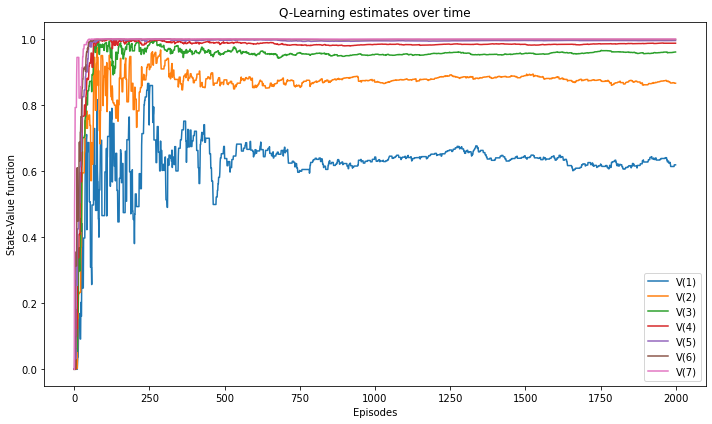

In [8]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)', 'V(6)', 'V(7)']

plt.figure(figsize=(10,6))
plt.plot(V_track_ql[:,1:8])
plt.title('Q-Learning estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)
plt.tight_layout()
plt.show()